In [1]:
# %pip install --upgrade --user xarray matplotlib numpy

In [2]:
# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import external packages
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add path with self-created packages and import them
import sys
sys.path.append('./src')
import sciebo

# Spike Count Analysis

Spiking actvitiy of neurons is the man focus of the [Steinmetz et al, 2019 paper](https://www.nature.com/articles/s41586-019-1787-x). With the rich dataset that they collected during their experiments many analyses are possible that can link neural activity to behavioral or experimental variables.

This notebook has a different flavor compared to the other notebooks we worked with before. It tries to resemble a scenario where we are given the data, and we need to explore it and learn more about it, and answer some questions. Questions are more generic and there are less hints.

We will be using Numpy and Matplotlib to filter, transform, and visualize the spike counts and explore their link to other variables.

**NumPy**

| Code                                             | Description                                                                                                                     |
|--------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| `array = dataset["key"].to_numpy()`              | Converts a dataset column to a NumPy array.                                                                                     |
| `array.shape`                                    | Retrieves the shape (dimensions) of the NumPy array.                                                                             |
| `np.unique(array)`                               | Finds unique elements in the array.                                                                                              |
| `filtered_array = array1[array2 == 'value']`     | Filters `array1`, selecting elements at positions where `array2` is equal to the specified value.                                |
| `np.sum(array)`                                  | Sums all the elements in the array.                                                                                              |
| `masked_array = array1[:, array2 == 'value', :]` | Applies a boolean mask from `array2` to `array1`, only across the 2nd dimension. |
| `np.mean(array, axis=0)`                         | Computes the mean across the 1st dimension (rows) for each element of the 2nd dimension.                                   |
| `np.mean(array, axis=1)`                         | Computes the mean across the 2nd dimension (columns) for each element of the 1st dimension.                                 |
| `np.mean(array, axis=(0, 1))`                    | Computes the mean of the array across both the 1st and 2nd dimensions.                                                           |
| `np.corrcoef(data_array)`                    | Computes the correlation coefficient matrix of an array.                                            |

**Matplotlib**

| Code                                         | Description                                                                                         |
|----------------------------------------------|-----------------------------------------------------------------------------------------------------|
| `plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)` | Creates a new figure with specified size and resolution.                                            |
| `plt.imshow(data_array, aspect='auto', cmap='color_map_name')` | Displays data as an image with specified aspect ratio and colormap.                                 |
| `plt.xlabel('label_text')`                   | Sets the label for the x-axis.                                                                      |
| `plt.ylabel('label_text')`                   | Sets the label for the y-axis.                                                                      |
| `plt.colorbar(label='label_text')`           | Adds a color bar to the plot with a label.                                                          |
| `plt.hist(data_array, bins=number_of_bins, alpha=transparency, label='label_text')` | Plots a histogram with specified bins, transparency, and label for the dataset.                     |
| `plt.legend()`                               | Displays a legend on the plot.                                                                      |
| `plt.title('title_text')`                    | Sets the title of the plot.                                                                         |

---

### Download the dataset

In [3]:
sciebo.download_from_sciebo('https://uni-bonn.sciebo.de/s/YT3iaH9Po0LJMxR', f'data/steinmetz_2017-12-05_Lederberg.nc')

### Load the dataset using Xarray

In [4]:
dset = xr.load_dataset(f"./data/steinmetz_2017-12-05_Lederberg.nc")
dset

<xarray.Dataset>
Dimensions:             (trial: 340, time: 250, cell: 698,
                         waveform_component: 3, sample: 82, probe: 384,
                         brain_area_lfp: 12, spike_id: 3185888)
Coordinates:
  * trial               (trial) int32 1 2 3 4 5 6 7 ... 335 336 337 338 339 340
  * time                (time) float64 0.01 0.02 0.03 0.04 ... 2.48 2.49 2.5
  * cell                (cell) int32 1 2 3 4 5 6 7 ... 693 694 695 696 697 698
  * waveform_component  (waveform_component) int32 1 2 3
  * probe               (probe) int32 1 2 3 4 5 6 7 ... 379 380 381 382 383 384
  * brain_area_lfp      (brain_area_lfp) object 'DG' 'LGd' ... 'MD' 'VISam'
  * spike_id            (spike_id) int32 1 2 3 4 ... 3185886 3185887 3185888
Dimensions without coordinates: sample
Data variables: (12/31)
    contrast_left       (trial) int8 0 0 0 100 25 50 0 0 100 ... 0 0 0 0 0 0 0 0
    contrast_right      (trial) int8 0 0 0 50 50 50 ... 100 100 100 100 100 100
    gocue               (trial) float64 0.4884 0.5617 0.6277 ... 0.7894 0.7892
    stim_onset          (trial) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    feedback_type       (trial) float64 1.0 -1.0 1.0 1.0 ... -1.0 -1.0 -1.0 -1.0
    feedback_time       (trial) float64 2.028 0.9821 2.175 ... 2.181 2.331 2.316
    ...                  ...
    waveform_w          (cell, sample, waveform_component) float32 0.0 ... 0....
    waveform_u          (cell, waveform_component, probe) float32 0.0 ... -0....
    lfp                 (brain_area_lfp, trial, time) float64 -57.29 ... -15.9
    spike_time          (spike_id) float32 0.01967 0.09227 ... 2.355 2.475
    spike_cell          (spike_id) uint32 1 1 1 1 1 1 ... 698 698 698 698 698
    spike_trial         (spike_id) uint32 1 1 1 1 1 1 ... 450 450 450 450 450

---

## Region-specific Spike Count Analysis

Neurons in this dataset are also label with their brain area. Let's take advantage of this additional information and explore the spiking activity for different brain areas and compare them with each other.

**Example** Load the spike_count data from the Xarray dataset, and check the shape of it (how many elements are in each dimension?)

In [5]:
spike_counts = dset["spike_count"].to_numpy()
spike_counts.shape

(698, 340, 250)

Load the brain_groups data from the Xarray dataset, and check its shape.

In [6]:
brain_area = dset["brain_groups"].to_numpy()
brain_area.shape

(698,)

Which brain areas (let's use the `"brain_groups"` variable for this) were recorded in this dataset?

In [7]:
np.unique(brain_area)

array(['hippocampus', 'non-visual cortex', 'root', 'thalamus',
       'visual cortex'], dtype=object)

What is the total spike counts for the neurons recorded from Visual Cortex?

In [21]:
brain_area

array(['visual cortex', 'visual cortex', 'visual cortex', 'hippocampus',
       'visual cortex', 'visual cortex', 'hippocampus', 'hippocampus',
       'visual cortex', 'visual cortex', 'hippocampus', 'hippocampus',
       'visual cortex', 'visual cortex', 'hippocampus', 'visual cortex',
       'visual cortex', 'visual cortex', 'hippocampus', 'hippocampus',
       'hippocampus', 'visual cortex', 'hippocampus', 'visual cortex',
       'visual cortex', 'visual cortex', 'hippocampus', 'visual cortex',
       'hippocampus', 'hippocampus', 'hippocampus', 'hippocampus',
       'hippocampus', 'hippocampus', 'hippocampus', 'visual cortex',
       'visual cortex', 'hippocampus', 'visual cortex', 'hippocampus',
       'hippocampus', 'visual cortex', 'hippocampus', 'hippocampus',
       'hippocampus', 'thalamus', 'hippocampus', 'visual cortex',
       'visual cortex', 'hippocampus', 'hippocampus', 'visual cortex',
       'hippocampus', 'hippocampus', 'hippocampus', 'visual cortex',
       'hippoca

In [20]:
region_mask = (brain_area == 'visual cortex')
region_mask
# total_spike_count_region = np.sum(spike_counts[region_mask])
# total_spike_count_region

array([ True,  True,  True, False,  True,  True, False, False,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
       False, False, False,  True, False,  True,  True,  True, False,
        True, False, False, False, False, False, False, False,  True,
        True, False,  True, False, False,  True, False, False, False,
       False, False,  True,  True, False, False,  True, False, False,
       False,  True, False, False,  True,  True, False,  True, False,
        True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False,  True, False,  True, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False,  True,  True, False, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True, False, False,
       False, False,

Compute the mean spike counts across all cell in the Visual Cortext. This essentially gives us the population activity for every trial across time. Let's plot it using `plt.imshow()`.

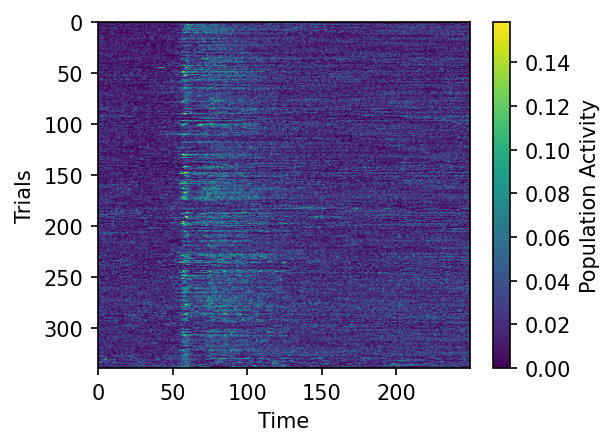

In [9]:
region_mask = (brain_area == 'visual cortex')
region_spike_counts = spike_counts[region_mask, :, :]
population_activity = region_spike_counts.mean(axis=0)

plt.figure(figsize=(4, 3), dpi=150)
plt.imshow(population_activity, aspect='auto', cmap='viridis')
plt.xlabel('Time')
plt.ylabel('Trials')
plt.colorbar(label="Population Activity")

If, in addition to the cells, we also take the average across time, we are left with a single value per trial representing the per-trial population activity averaged over time. Compare the population activity average over time between all neurons and Visual Cortex neurons. Is the Visual Cortex more active or less active compared to all areas together?

Text(0.5, 1.0, 'Comparative Histogram of Mean Spike Counts')

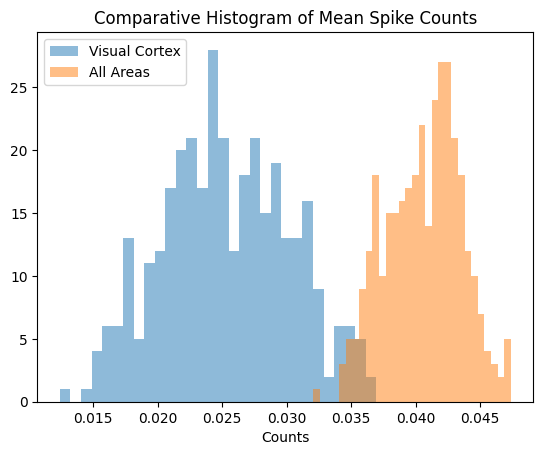

In [10]:
region_mask = (brain_area == 'visual cortex')
visual_cortex_population_activity = spike_counts[region_mask].mean(axis=(0, 2))
all_areas_population_activity = spike_counts.mean(axis=(0, 2))

plt.hist(visual_cortex_population_activity, bins=30, alpha=0.5, label='Visual Cortex')
plt.hist(all_areas_population_activity, bins=30, alpha=0.5, label='All Areas')
plt.xlabel("Avg Ppoulation Activity")
plt.xlabel("Counts")
plt.legend()
plt.title('Comparative Histogram of Mean Spike Counts')

If Visual Cortex has a higher or lower activity compared to all areas together, then there must be some other areas that is compensating for that. Which area is that?

Text(0.5, 1.0, 'Comparative Histogram of Mean Spike Counts')

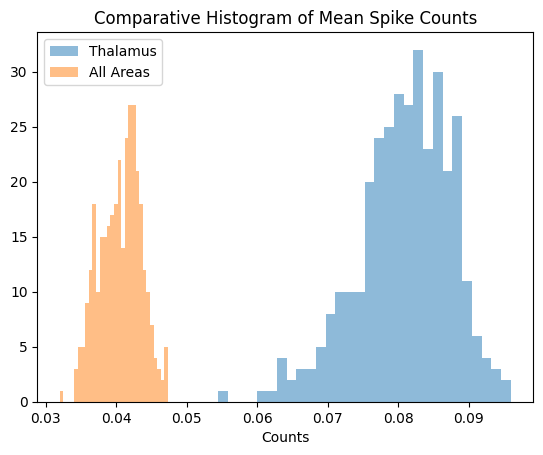

In [11]:
region_mask = (brain_area == 'thalamus')
visual_cortex_population_activity = spike_counts[region_mask].mean(axis=(0, 2))
all_areas_population_activity = spike_counts.mean(axis=(0, 2))

plt.hist(visual_cortex_population_activity, bins=30, alpha=0.5, label='Thalamus')
plt.hist(all_areas_population_activity, bins=30, alpha=0.5, label='All Areas')
plt.xlabel("Avg Ppoulation Activity")
plt.xlabel("Counts")
plt.legend()
plt.title('Comparative Histogram of Mean Spike Counts')

Compute correlation of average spike count between all the neurons in Visual Cortex, and visualize it using `plt.imshow()`.

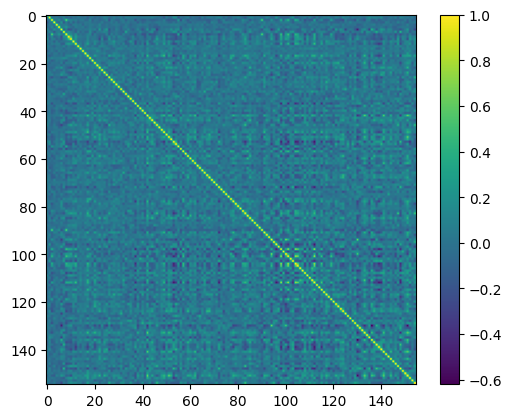

In [12]:
region_mask = (brain_area == 'thalamus')
correlation_matrix = np.corrcoef(spike_counts[region_mask].mean(axis=2))
plt.imshow(correlation_matrix)
plt.colorbar()

---

## Spike Count Analysis with Trial-level Categorical Variables

As we have seen before, in addition to brain area, we also have access to several categorical variables such as response type and stimulus contrast level. Let's see whether the pattern of neural activity would change for different values of these categorical variables. 

Let's start by turning the spike counts into firing rates. **Hint:** we need the size of the time bin for this.

In [13]:
dt = .01
firing_rate = spike_counts / dt

Load the `"response_type"` variable as a numpy array. What is its shape? Which dimension of the firing rate data does it match to in terms of number of elements? 

In [14]:
response_type = dset["response_type"].to_numpy()
response_type.shape, firing_rate.shape

((340,), (698, 340, 250))

**Example:** Plot the mean firing rate (averaged across neurons and trials) over time, taking all neurons (no area specification).

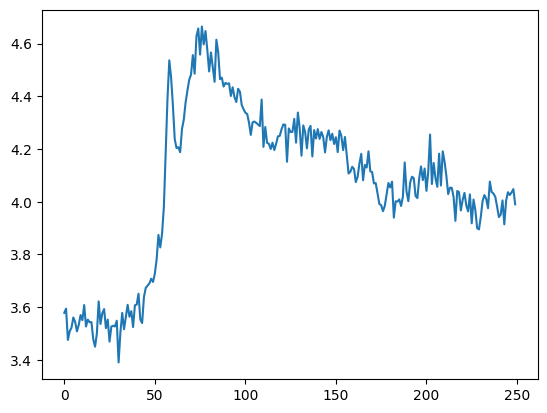

In [15]:
plt.plot(firing_rate.mean(axis=(0, 1)))

Plot the same data in the previous exercise, but only considering the trials where the response was -1.

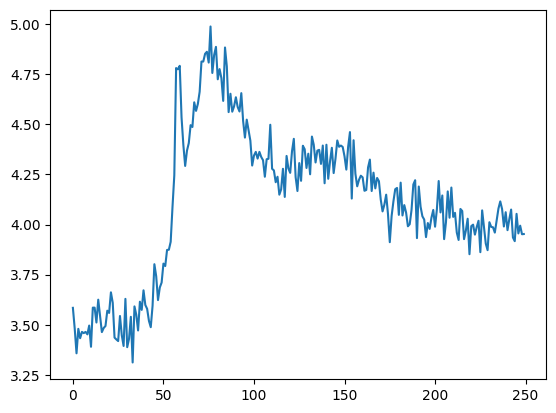

In [16]:
plt.plot(firing_rate[:, response_type==-1, :].mean(axis=(0, 1)))

Add to the previous plot the other two response types: one line for each response type. Did the population activity of Visual Cortex change noticable between the response types?

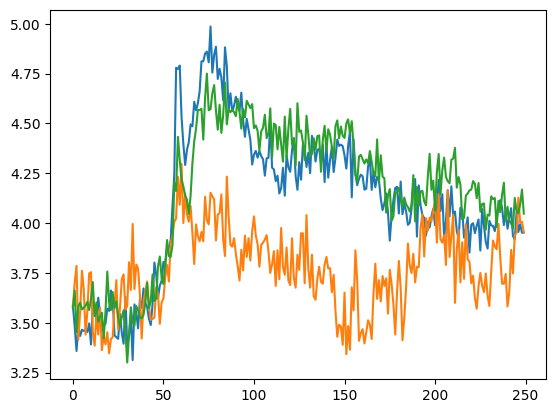

In [17]:
plt.plot(firing_rate[:, response_type==-1, :].mean(axis=(0, 1)))
plt.plot(firing_rate[:, response_type==0, :].mean(axis=(0, 1)))
plt.plot(firing_rate[:, response_type==1, :].mean(axis=(0, 1)))

Plot the same thing as in the previous exercise, but only for neurons in the Visual Cortex.

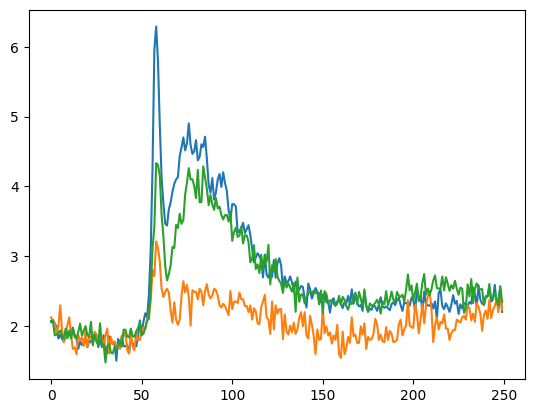

In [18]:
region_mask = (brain_area == "visual cortex")
plt.plot(firing_rate[region_mask][:, response_type==-1, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==0, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==1, :].mean(axis=(0, 1)))

Using subplots, create four plots in a single figure, each plotting showing the the analysis in the previous exercise for a different brain area. Specify the brain area in the title.

Text(0.5, 1.0, 'non-visual cortex')

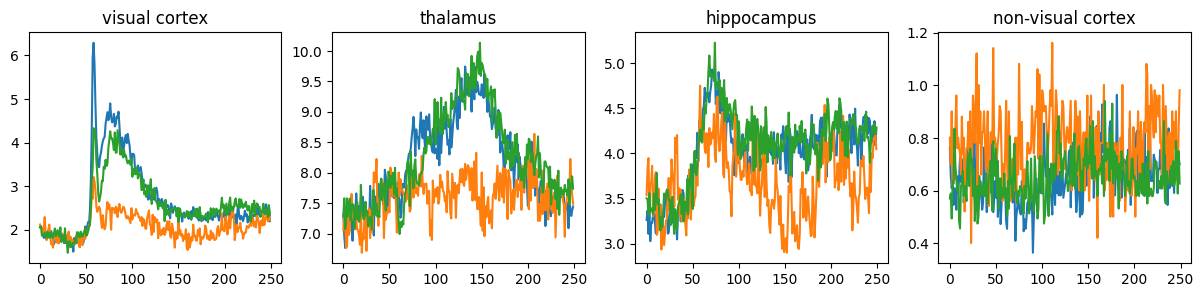

In [19]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 4, 1)
region_mask = (brain_area == "visual cortex")
plt.plot(firing_rate[region_mask][:, response_type==-1, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==0, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==1, :].mean(axis=(0, 1)))
plt.title("visual cortex")

plt.subplot(1, 4, 2)
region_mask = (brain_area == "thalamus")
plt.plot(firing_rate[region_mask][:, response_type==-1, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==0, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==1, :].mean(axis=(0, 1)))
plt.title("thalamus")

plt.subplot(1, 4, 3)
region_mask = (brain_area == "hippocampus")
plt.plot(firing_rate[region_mask][:, response_type==-1, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==0, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==1, :].mean(axis=(0, 1)))
plt.title("hippocampus")

plt.subplot(1, 4, 4)
region_mask = (brain_area == 'non-visual cortex')
plt.plot(firing_rate[region_mask][:, response_type==-1, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==0, :].mean(axis=(0, 1)))
plt.plot(firing_rate[region_mask][:, response_type==1, :].mean(axis=(0, 1)))
plt.title('non-visual cortex')